In [161]:
"""analyze between odd and even runs """

'analyze between odd and even runs '

In [162]:
# %load subject_class.py
from __future__ import print_function, division
import re
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

class subject(object):
    """try to organize data based on subject ex sub001"""
    def __init__(self,sub):
        # subject info ex: 'sub001'
        self.sub_id = sub

        # check if the input is valid
        valid_sub = ["sub001", "sub002", "sub003", "sub004", "sub005", "sub006"]
        assert self.sub_id in valid_sub, "%s is not a valid input" % self.sub_id

        # BOLD folder for this subject
        sub_BOLD_path = "../data/ds105/%s/BOLD/" %self.sub_id

        # anatomy folder for this subject
        sub_anatomy_file = "../data/ds105/%s/anatomy/highres001_brain.nii.gz" %self.sub_id
        
        # runfile_list: ['task001_run001', 'task001_run002'......]
        runfile_list = ['task001_run'+ i+ '.txt' for i in ['001','002','003','004','005','006','007','008','009','010','011','012']]
        runlist = ['run'+ i for i in ['001','002','003','004','005','006','007','008','009','010','011','012']]
        # deal with sub005 which has only 11 run results
        if self.sub_id == "sub005":
            runfile_list = runfile_list[:-1]
            runlist = runlist[:-1]

        # TR info:
        self.TR = 2.5
        
        # load high resolution brain structure for this subject
        self.brain_img = nib.load(sub_anatomy_file)
        
        # load all bold image file for this subject
        self.run_img_result = {}
        for i in runlist:
            self.run_img_result[self.sub_id + '_' + i] = nib.load(sub_BOLD_path+'task001_'+i+'/bold.nii.gz')
        
        # ordered run keys:
        ordered_run_keys = self.run_img_result.keys()
        ordered_run_keys.sort()
        self.run_keys = ordered_run_keys

        # shape of the BOLD data:
        self.BOLD_shape = self.run_img_result[self.run_keys[1]].shape
        
        # conditions setting: which condition is for which category
        self.condition_key_file = open("../data/ds105/models/model001/condition_key.txt")
        condition_list = self.condition_key_file.readlines()
        condition = re.compile(r'(cond\d+) (\w+)')
        result = {}
        for item in condition_list:
            for match in condition.finditer(item):
                result[match.group(1)] = match.group(2)
        self.condition_key = result
        
        # condition files for each objects for each run
        sub_condition_path = "../data/ds105/%s/model/model001/onsets/" %self.sub_id
        self.conditions = {}
        for i in runfile_list:
            for j in self.condition_key.keys():
                self.conditions[i[8:14]+'-'+self.condition_key[j]] = sub_condition_path + i[:-4]+'/'+j+'.txt'
                   
                



In [163]:
# work on subject 001
sub1 = subject("sub001")

In [164]:
# %load diagnostics.py
""" Diagnostics.py

A collection of utility functions for diagnostics on FMRI data

See test_* functions in this directory for nose tests
"""
# import important library

from __future__ import division, print_function, absolute_import
import numpy as np
import nibabel as nib

def vol_std(data):
    """ Return standard deviation across voxels for 4D array `data`

    Parameters
    ----------
    data : 4D array
        4D array from FMRI run with last axis indexing volumes.  Call the shape
        of this array (M, N, P, T) where T is the number of volumes.

    Returns
    -------
    std_values : array shape (T,)
        One dimensonal array where ``std_values[i]`` gives the standard
        deviation of all voxels contained in ``data[..., i]``.
    """

    result = [0] * data.shape[-1]
    for i in range(len(result)):
        result[i] = np.std(data[:,:,:,i])
    return result


def iqr_outliers(arr_1d, iqr_scale=1.5):
    """ Return indices of outliers identified by interquartile range

    Parameters
    ----------
    arr_1d : 1D array
        One-dimensional numpy array, from which we will identify outlier
        values.
    iqr_scale : float, optional
        Scaling for IQR to set low and high thresholds.  Low threshold is given
        by 25th centile value minus ``iqr_scale * IQR``, and high threshold id
        given by 75 centile value plus ``iqr_scale * IQR``.

    Returns
    -------
    outlier_indices : array
        Array containing indices in `arr_1d` that contain outlier values.
    lo_hi_thresh : tuple
        Tuple containing 2 values (low threshold, high thresold) as described
        above.
    """
    # Hint : np.lookfor('centile')
    # Hint : np.lookfor('nonzero')
    
    # get parameters
    IQR = np.percentile(arr_1d, 75) - np.percentile(arr_1d, 25)
    lo_thresh = np.percentile(arr_1d, 25) - IQR * iqr_scale
    hi_thresh = np.percentile(arr_1d, 75) + IQR * iqr_scale
    
    # find outlier_indeces
    outlier_indices = []
    for index in range(len(arr_1d)):
        if arr_1d[index] < lo_thresh or arr_1d[index] > hi_thresh:
            outlier_indices.append(index)
    return (outlier_indices, (lo_thresh, hi_thresh))
    

def vol_rms_diff(arr_4d):
    """ Return root mean square of differences between sequential volumes

    Parameters
    ----------
    data : 4D array
        4D array from FMRI run with last axis indexing volumes.  Call the shape
        of this array (M, N, P, T) where T is the number of volumes.

    Returns
    -------
    rms_values : array shape (T-1,)
        One dimensonal array where ``rms_values[i]`` gives the square root of
        the mean (across voxels) of the squared difference between volume i and
        volume i + 1.
    """
    
    time_length = arr_4d.shape[-1]
    diff_vol = []
    for item in range(time_length -1):
        diff_vol.append(arr_4d[...,item+1] - arr_4d[...,item])
    rms_values = []
    for i in diff_vol:
        rms_values.append(np.sqrt(np.mean(i**2)))
   
    return rms_values


def extend_diff_outliers(diff_indices):
    """ Extend difference-based outlier indices `diff_indices` by pairing

    Parameters
    ----------
    diff_indices : array
        Array of indices of differences that have been detected as outliers.  A
        difference index of ``i`` refers to the difference between volume ``i``
        and volume ``i + 1``.

    Returns
    -------
    extended_indices : array
        Array where each index ``j`` in `diff_indices has been replaced by two
        indices, ``j`` and ``j+1``, unless ``j+1`` is present in
        ``diff_indices``.  For example, if the input was ``[3, 7, 8, 12, 20]``,
        ``[3, 4, 7, 8, 9, 12, 13, 20, 21]``.
    """

    extended_indices = []
    for item in diff_indices:
        if item not in extended_indices:
            extended_indices.append(item)
        if (item+1) not in extended_indices:
            extended_indices.append(item+1)
    
    return extended_indices




In [165]:
# load matplotlib
%matplotlib inline

In [166]:
# get image files for subject 1
sub1_img = sub1.run_img_result

In [210]:
sub1_img.keys()

['sub001_run012',
 'sub001_run006',
 'sub001_run007',
 'sub001_run004',
 'sub001_run005',
 'sub001_run002',
 'sub001_run003',
 'sub001_run001',
 'sub001_run010',
 'sub001_run011',
 'sub001_run008',
 'sub001_run009']

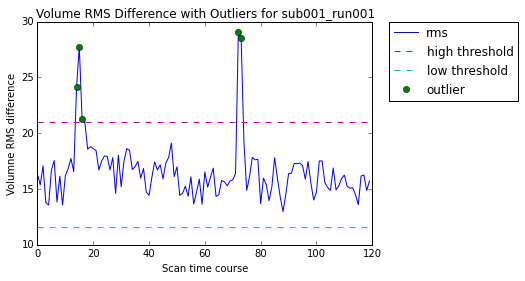

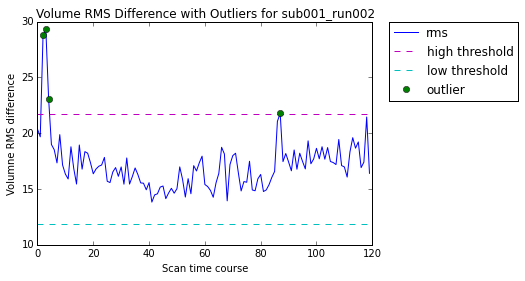

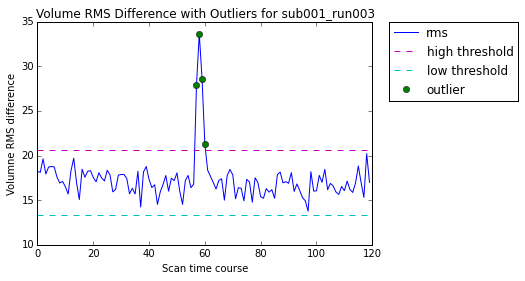

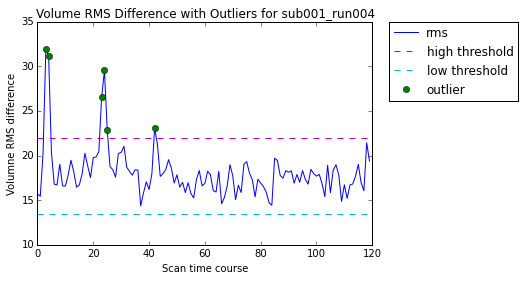

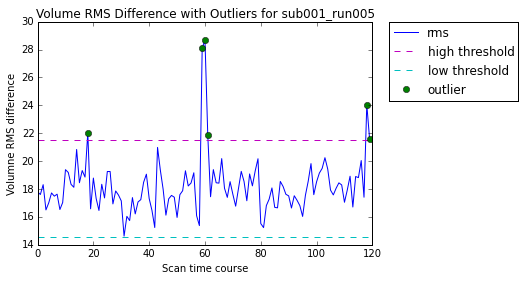

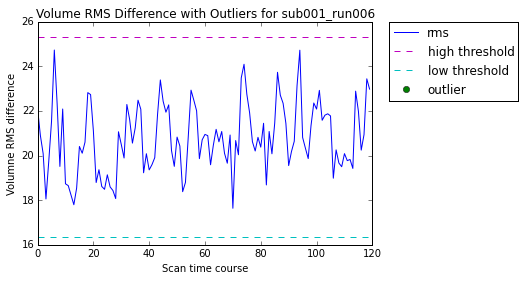

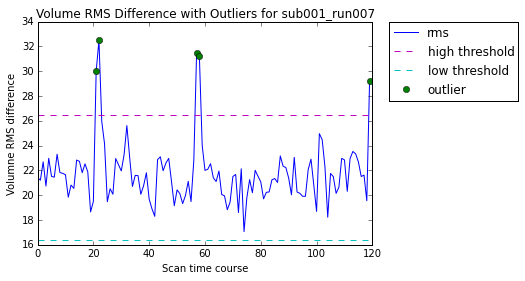

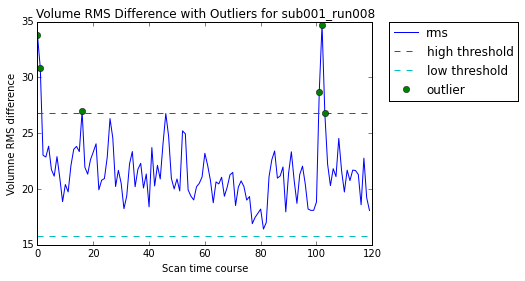

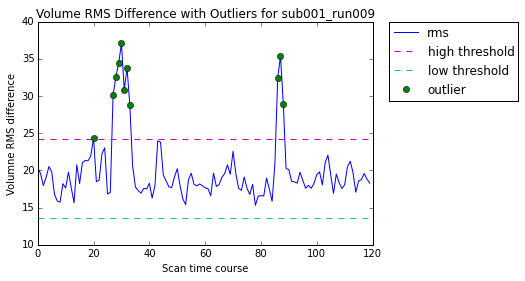

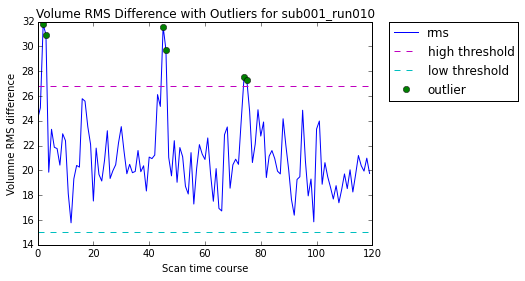

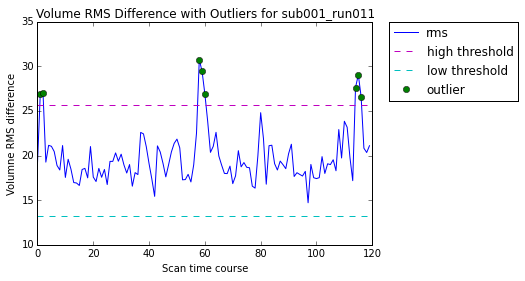

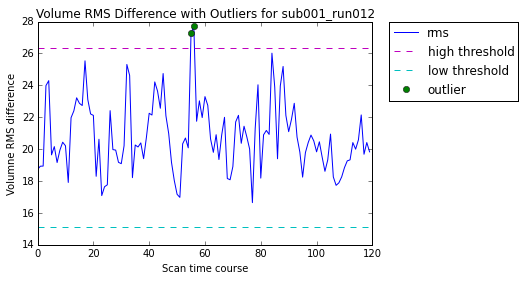

In [167]:
# use rms_diff to check outlier for all 12 runs for subject 1

for key in sub1.run_keys:
    data = sub1_img[key].get_data()
    rms_diff = vol_rms_diff(data)
    rms_outlier_indices, rms_thresh = iqr_outliers(rms_diff)
    y_value2 = [rms_diff[i] for i in rms_outlier_indices]
    
    plt.figure()
    plt.plot(rms_diff, label = 'rms')
    plt.plot([0,len(rms_diff)],[rms_thresh[1],rms_thresh[1]], "k--",\
    label = 'high threshold', color='m')
    plt.plot([0,len(rms_diff)],[rms_thresh[0],rms_thresh[0]], "k--",\
    label = 'low threshold', color='c')
    plt.plot(rms_outlier_indices, y_value2, 'o', color = 'g', label = 'outlier')
    plt.xlabel('Scan time course')
    plt.ylabel('Volumne RMS difference')
    plt.title('Volume RMS Difference with Outliers for %s' % key)
    plt.subplot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., numpoints = 1) 


In [168]:
# %load outlier.py
# remove data outliers from the data by using rms_diff and extend indices
def remove_data_outlier (img_dict):
    result = {}
    outlier_index = {}
    for key, imgresult in img_dict.iteritems():
        result[key] = imgresult.get_data()
        rms_diff = vol_rms_diff(result[key])
        rms_outlier_indices, rms_thresh = iqr_outliers(rms_diff)
        rms_extend_indices = extend_diff_outliers(rms_outlier_indices)
        outlier_index[key] = rms_extend_indices
        result[key] = np.delete(result[key], outlier_index[key], axis = 3)
    return result, outlier_index



In [169]:
# remove outlier from images
sub1_clean_img, outlier_index  = remove_data_outlier(sub1_img)

In [170]:
# check keys
sub1_clean_img.keys()

['sub001_run001',
 'sub001_run006',
 'sub001_run007',
 'sub001_run004',
 'sub001_run005',
 'sub001_run002',
 'sub001_run003',
 'sub001_run012',
 'sub001_run011',
 'sub001_run009',
 'sub001_run008',
 'sub001_run010']

In [171]:
# check if the size changes: for sub001_run001: 121 -> 114
sub1_clean_img["sub001_run001"].shape

(40, 64, 64, 114)

In [172]:
# get general all tr times == 121*2.5 = about 300 s
# this is the x-axis to plot hemodynamic prediction
all_tr_times = np.arange(sub1.BOLD_shape[-1]) * sub1.TR

In [173]:
# %load get_object_neural.py

def get_object_neural(sub_ID, condition_dict, TR, n_vox, object_name="all", check=0):
    """
    get object neural array for specific object from all runs, odd runs or even runs
    
    parameters
    ----------
    condition_dict: dictionary of all condition files
    object_name: desired object name: 'house','scrambledpix','cat','shoe','bottle','scissors','chair','face'
    TR: TR for fMRI
    n_vox: time course of fMRI
    check: 1= odd runs, 2=even runs, others = all runs
    
    output
    -------
    a dictionary of run name : (neural array, path of the bold image) for that run
    ex:
    
    {
    'run001-bottle-neural': (array([ 0.,  0.,  0.,  0.,  0., ...]), bold path)
    'run002-bottle-neural': (array([ 0.,  0.,  0.,  0.,  0., ...]), bold path)
    }
    
    
    """

    # check if the object is valid
    valid_object = ["house", "scrambledpix", "cat", "shoe", "bottle", "scissors", "chair", "face", "all"]
    assert (object_name in valid_object)


    condition_dict_key = condition_dict.keys()
    result = {}

    # to get ALL
    if object_name == "all":
        for i in condition_dict_key:
            result[i] = (events2neural(condition_dict[i], TR, n_vox), "../data/ds105/%s/BOLD/task001_"% sub_ID + i[:6]+"/bold.nii.gz")

    else:
        for i in condition_dict_key:
            if check == 1:
                if object_name in i:
                    if int(i[3:6])%2 ==1:
                        result[i] = (events2neural(condition_dict[i], TR, n_vox), "../data/ds105/%s/BOLD/task001_"% sub_ID + i[:6]+"/bold.nii.gz")
            elif check == 2:
                if object_name in i:
                    if int(i[3:6])%2 ==0:
                        result[i] = (events2neural(condition_dict[i], TR, n_vox), "../data/ds105/%s/BOLD/task001_"% sub_ID + i[:6]+"/bold.nii.gz")
            else:
                if object_name in i:
                    result[i] = (events2neural(condition_dict[i], TR, n_vox), "../data/ds105/%s/BOLD/task001_"%sub_ID + i[:6]+"/bold.nii.gz")

    return result



In [174]:
# check all tr times: 0-300s
all_tr_times

array([   0. ,    2.5,    5. ,    7.5,   10. ,   12.5,   15. ,   17.5,
         20. ,   22.5,   25. ,   27.5,   30. ,   32.5,   35. ,   37.5,
         40. ,   42.5,   45. ,   47.5,   50. ,   52.5,   55. ,   57.5,
         60. ,   62.5,   65. ,   67.5,   70. ,   72.5,   75. ,   77.5,
         80. ,   82.5,   85. ,   87.5,   90. ,   92.5,   95. ,   97.5,
        100. ,  102.5,  105. ,  107.5,  110. ,  112.5,  115. ,  117.5,
        120. ,  122.5,  125. ,  127.5,  130. ,  132.5,  135. ,  137.5,
        140. ,  142.5,  145. ,  147.5,  150. ,  152.5,  155. ,  157.5,
        160. ,  162.5,  165. ,  167.5,  170. ,  172.5,  175. ,  177.5,
        180. ,  182.5,  185. ,  187.5,  190. ,  192.5,  195. ,  197.5,
        200. ,  202.5,  205. ,  207.5,  210. ,  212.5,  215. ,  217.5,
        220. ,  222.5,  225. ,  227.5,  230. ,  232.5,  235. ,  237.5,
        240. ,  242.5,  245. ,  247.5,  250. ,  252.5,  255. ,  257.5,
        260. ,  262.5,  265. ,  267.5,  270. ,  272.5,  275. ,  277.5,
      

In [175]:
# %load stimuli.py
""" Functions to work with standard OpenFMRI stimulus files

The functions have docstrings according to the numpy docstring standard - see:

    https://github.com/numpy/numpy/blob/master/doc/HOWTO_DOCUMENT.rst.txt
"""

import numpy as np

def events2neural(task_fname, tr, n_trs):
    """ Return predicted neural time course from event file `task_fname`

    Parameters
    ----------
    task_fname : str
        Filename of event file
    tr : float
        TR in seconds
    n_trs : int
        Number of TRs in functional run

    Returns
    -------
    time_course : array shape (n_trs,)
        Predicted neural time course, one value per TR
    """
    task = np.loadtxt(task_fname)
    # Check that the file is plausibly a task file
    if task.ndim != 2 or task.shape[1] != 3:
        raise ValueError("Is {0} really a task file?", task_fname)
    # Convert onset, duration seconds to TRs
    task[:, :2] = task[:, :2] / tr
    # Neural time course from onset, duration, amplitude for each event
    time_course = np.zeros(n_trs)
    for onset, duration, amplitude in task:
        time_course[onset:onset + duration] = amplitude
    return time_course


In [176]:
# the y-axis to plot hemodynamic prediction is the neural value from condition (on-off)
sub1_neural = get_object_neural(sub1.sub_id ,sub1.conditions, sub1.TR, sub1.BOLD_shape[-1])

In [177]:
# check keys
sub1_neural.keys()

['run003-house',
 'run008-bottle',
 'run010-shoe',
 'run008-scrambledpix',
 'run011-face',
 'run007-scrambledpix',
 'run012-shoe',
 'run010-house',
 'run011-scissors',
 'run006-house',
 'run007-face',
 'run011-shoe',
 'run004-cat',
 'run010-scissors',
 'run001-chair',
 'run011-cat',
 'run009-bottle',
 'run008-scissors',
 'run004-scrambledpix',
 'run001-bottle',
 'run008-chair',
 'run011-house',
 'run001-house',
 'run003-face',
 'run009-chair',
 'run002-scissors',
 'run004-house',
 'run003-scrambledpix',
 'run011-chair',
 'run012-cat',
 'run001-scissors',
 'run010-cat',
 'run002-scrambledpix',
 'run002-face',
 'run009-house',
 'run004-chair',
 'run007-bottle',
 'run012-bottle',
 'run005-scissors',
 'run012-scrambledpix',
 'run008-face',
 'run006-bottle',
 'run006-scissors',
 'run009-scissors',
 'run002-bottle',
 'run005-house',
 'run002-house',
 'run003-chair',
 'run011-scrambledpix',
 'run009-shoe',
 'run009-cat',
 'run006-cat',
 'run010-bottle',
 'run012-scissors',
 'run011-bottle',
 

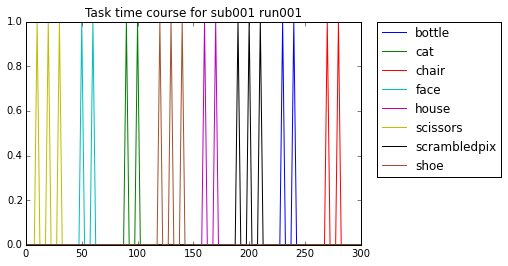

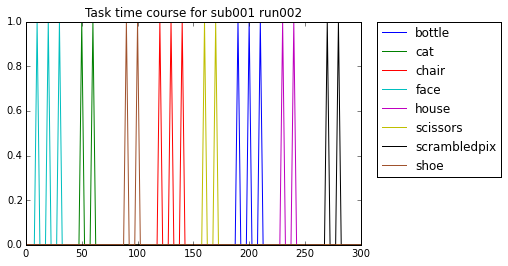

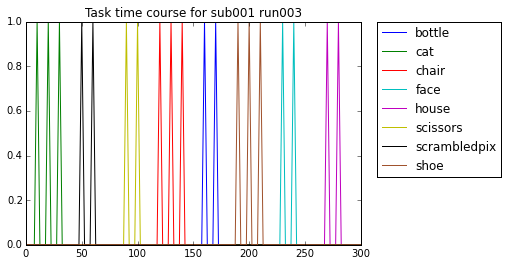

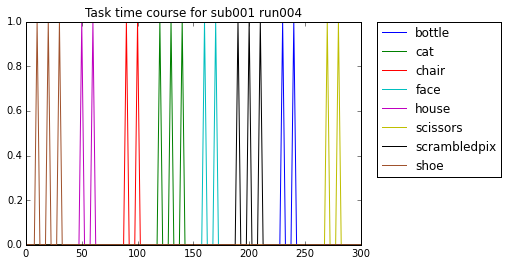

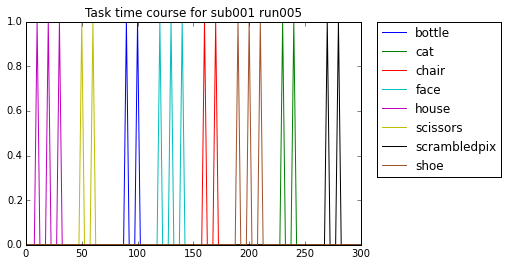

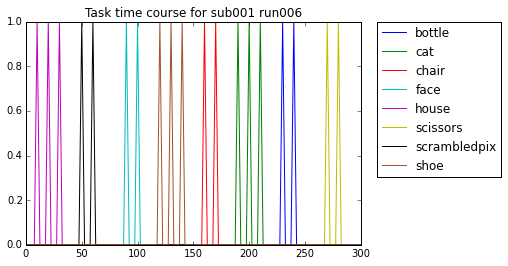

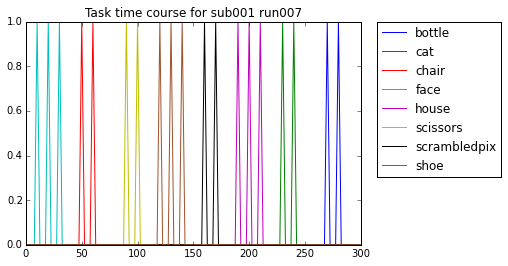

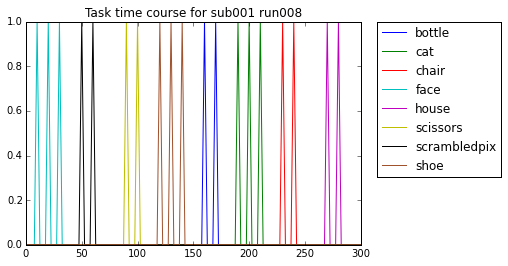

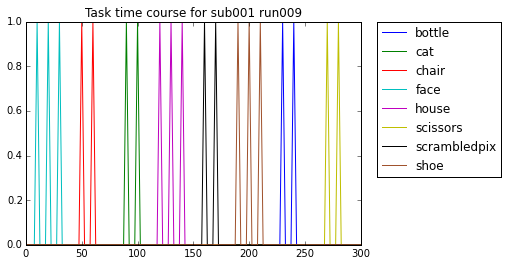

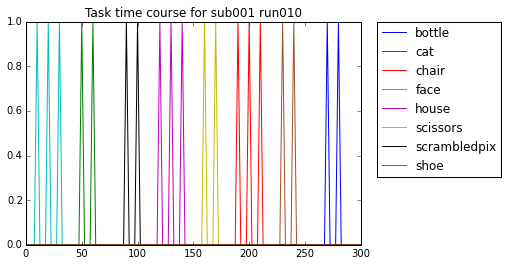

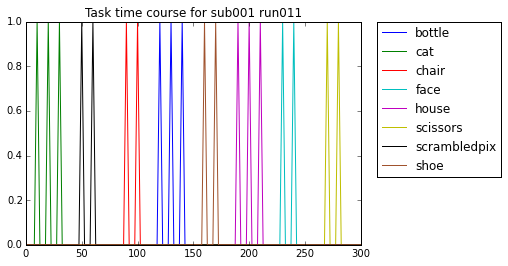

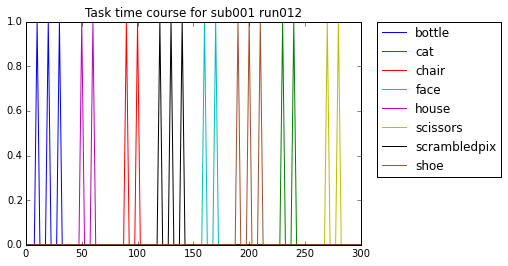

In [178]:
# show task_time_course for all runs
object_list = ["bottle", "cat", "chair", "face", "house", "scissors", "scrambledpix", "shoe"]
color_list = ["b","g","r","c","m","y","k","sienna"]
match_color = zip(object_list, color_list)
for i in range(1,13):
    plt.figure()
    for j in match_color:
        plt.plot(all_tr_times, sub1_neural["run0%02d-"%i+j[0]][0], label=j[0], c=j[1])
    plt.title("Task time course for sub001 run0%02d" %i)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., numpoints = 1)      

In [179]:
# %load convolution.py
"""trying to develop a function to get the convulsion of the time course"""
# noinspection PyUnresolvedReferences

import scipy.stats
from scipy.stats import gamma
import numpy as np

# hrf function from lecture
def hrf(tr_times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(tr_times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(tr_times, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6


# convolution and deal with overflow
def convolution(neural, hrf_at_trs):
    convolved = np.convolve(neural, hrf_at_trs)
    convolved = convolved[:-(len(hrf_at_trs)-1)]
    return convolved

# get all convolved result and save in a dictionary
def get_all_convolved (dictionary_of_all_neural):
    result = {}
    for i in dictionary_of_all_neural.keys():
        convolved = convolution(sub1_neural[i][0], hrf_at_trs)
        result[i] = convolved
    return result

# remove outlier in convolved results
def remove_outlier (subid ,convolsion_data_dict, outlier_directory, axis=0):
    """
    Parameters
    ----------
    subid = subject ID
    convolsion_data_dict: the convolsion dictionary
    outlier_directory: outlier dictionary
    axis: in this case, axis=0

    Returns
    -------
    dictionary of convolsion result without outlier
    """
    result = {}
    for i in convolsion_data_dict.keys():
        result[i] = np.delete(convolsion_data_dict[i], outlier_directory[subid + '_' + i[:6]], axis)
    return result

In [180]:
# assume true HRF starts at zero, and gets to zero sometime before 35 seconds.
tr_times = np.arange(0, 30, sub1.TR)
hrf_at_trs = hrf(tr_times)

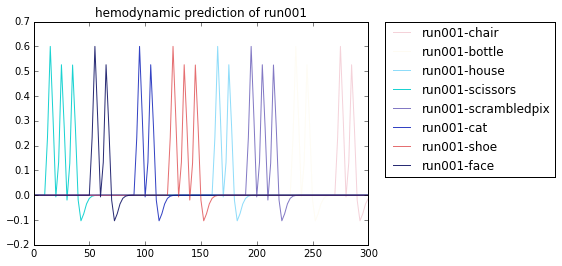

In [181]:
# get convolution data for each objects in this run -> show figure for run001
for i in sub1_neural.keys():
    if "run001" in i:
        convolved = convolution(sub1_neural[i][0], hrf_at_trs)
        plt.plot(all_tr_times, convolved, c=np.random.rand(4), label = "%s" % i)
plt.title("hemodynamic prediction of run001")
plt.subplot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
 

In [182]:
sub1_convolved = get_all_convolved(sub1_neural)

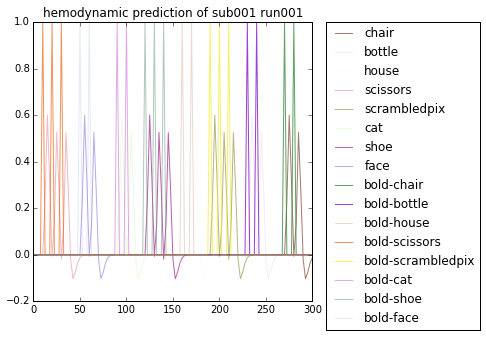

In [183]:
# show relationship between stimulation time and bold signals

# plot the convolsion/bold signal
plt.figure(figsize=(5,5))
for i in sub1_neural.keys():
    if "run001" in i:
        convolved = convolsion(sub1_neural[i][0], hrf_at_trs)
        plt.plot(all_tr_times, convolved, c=np.random.rand(4), label = "%s" % i[7:])
# plot the stimulation:
for i in sub1_neural.keys():
    if "run001" in i:
        plt.plot(all_tr_times, sub1_neural[i][0], c=np.random.rand(4), label = "bold-"+"%s"%i[7:])

plt.title("hemodynamic prediction of sub001 run001")
plt.subplot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
# plt.savefig("sub1_run1_stimulation_bold_prediction.png")

In [184]:
# remove outlier from convolved:
outlier_index.keys()

['sub001_run001',
 'sub001_run006',
 'sub001_run007',
 'sub001_run004',
 'sub001_run005',
 'sub001_run002',
 'sub001_run003',
 'sub001_run012',
 'sub001_run011',
 'sub001_run009',
 'sub001_run008',
 'sub001_run010']

In [185]:
# remind: sub1_convolved:
sub1_convolved.keys()

['run003-house',
 'run008-bottle',
 'run010-shoe',
 'run008-scrambledpix',
 'run011-face',
 'run007-scrambledpix',
 'run012-shoe',
 'run010-house',
 'run011-scissors',
 'run006-house',
 'run007-face',
 'run011-shoe',
 'run004-cat',
 'run010-scissors',
 'run001-chair',
 'run011-cat',
 'run009-bottle',
 'run008-scissors',
 'run004-scrambledpix',
 'run001-bottle',
 'run008-chair',
 'run011-house',
 'run001-house',
 'run003-face',
 'run009-chair',
 'run002-scissors',
 'run004-house',
 'run003-scrambledpix',
 'run011-chair',
 'run012-cat',
 'run001-scissors',
 'run010-cat',
 'run002-scrambledpix',
 'run002-face',
 'run009-house',
 'run004-chair',
 'run007-bottle',
 'run012-bottle',
 'run005-scissors',
 'run012-scrambledpix',
 'run008-face',
 'run006-bottle',
 'run006-scissors',
 'run005-shoe',
 'run002-bottle',
 'run005-house',
 'run002-house',
 'run003-chair',
 'run011-scrambledpix',
 'run009-shoe',
 'run009-cat',
 'run006-cat',
 'run010-bottle',
 'run012-scissors',
 'run011-bottle',
 'run

In [186]:
# remove outlier from convolved results
sub1_convolved = remove_outlier(sub1.sub_id, sub1_convolved, outlier_index)

In [187]:
# %load smooth.py
"""smooth images"""
# noinspection PyUnresolvedReferences
import scipy.ndimage as snd

def smooth (img_dict):
    """
    smooth images with
    Parameters
    ----------
    img_dict: dictionary of images for one subject

    Returns
    -------
    dictionary of smooth results

    """
    result = {}
    for key, img in img_dict.iteritems():
        result[key] = snd.gaussian_filter(img, 1)

    return result


In [188]:
# sub001 clean and smooth img == sub1_cs_img
sub1_cs_img = smooth(sub1_clean_img)

In [189]:
sub1_cs_img.keys()

['sub001_run012',
 'sub001_run006',
 'sub001_run007',
 'sub001_run004',
 'sub001_run005',
 'sub001_run002',
 'sub001_run003',
 'sub001_run001',
 'sub001_run011',
 'sub001_run010',
 'sub001_run008',
 'sub001_run009']

In [190]:
# linear regression


In [191]:
# %load linear_model.py

import numpy.linalg as npl
from scipy.stats import t as t_dist

def batch_make_design(img_dict, convolved_dict):
    matrix = {}
    object_list = ["bottle", "cat", "chair", "face", "house", "scissors", "scrambledpix", "shoe"]
    for key, img in img_dict.iteritems():
        time_course = img.shape[-1]
        matrix[key] = np.ones((time_course,(len(object_list)+3)))
        for i in xrange(matrix[key].shape[-1]-3):
            matrix[key][:,i] = convolved_dict[key[7:] +"-"+ object_list[i]]
        LD = np.linspace(-1,1,time_course)
        LD2 = LD**2
        LD2 = LD2 - np.mean(LD2)
        matrix[key][:, -3] = LD
        matrix[key][:, -2] = LD2
    return matrix


def scale_design_mtx(X):
    """utility to scale the design matrix for display
    This scales the columns to their own range so we can see the variations
    across the column for all the columns, regardless of the scaling of the
    column.
    """
    mi, ma = X.min(axis=0), X.max(axis=0)

    # Vector that is True for columns where values are not
    # all almost equal to each other
    col_neq = (ma - mi) > 1.e-8
    Xs = np.ones_like(X)
    # Leave columns with same value throughout with 1s
    # Scale other columns to min, max in column
    mi = mi[col_neq]
    ma = ma[col_neq]
    Xs[:,col_neq] = (X[:,col_neq] - mi)/(ma - mi)
    return Xs


def batch_scale_matrix (matrix_dict):
    result = {}
    for key, matrix in matrix_dict.iteritems():
        result[key] = scale_design_mtx(matrix)
    return result

def batch_convert_2d (img_dict):
    result = {}
    for key, img in img_dict.iteritems():
        result[key] = np.reshape(img, (-1, img.shape[-1]))
    return result

def t_stat(y, X, c):
    """ betas, t statistic and significance test given data, design matrix, contrast
    This is OLS estimation; we assume the errors to have independent
    and identical normal distributions around zero for each $i$ in
    $\e_i$ (i.i.d).
    """
    # Make sure y, X, c are all arrays
    #y = np.asarray(y)
    #X = np.asarray(X)
    #c = c.T
    c = np.atleast_2d(c).T # As column vector
    # Calculate the parameters - b hat
    beta = npl.pinv(X).dot(y)
    # The fitted values - y hat
    fitted = X.dot(beta)
    # Residual error
    errors = y - fitted
    # Residual sum of squares
    RSS = (errors**2).sum(axis=0)
    # Degrees of freedom is the number of observations n minus the number
    # of independent regressors we have used.  If all the regressor
    # columns in X are independent then the (matrix rank of X) == p
    # (where p the number of columns in X). If there is one column that
    # can be expressed as a linear sum of the other columns then
    # (matrix rank of X) will be p - 1 - and so on.
    df = X.shape[0] - npl.matrix_rank(X)
    # Mean residual sum of squares
    MRSS = RSS / df
    # calculate bottom half of t statistic
    #SE = np.sqrt(MRSS * c.T.dot(npl.pinv(X.T.dot(X)).dot(c)))
    SE = np.sqrt(MRSS * c.T.dot(npl.pinv(X.T.dot(X)).dot(c)))
    t = c.T.dot(beta) / SE
    # Get p value for t value using cumulative density dunction
    # (CDF) of t distribution
    ltp = t_dist.cdf(t, df) # lower tail p
    p = 1 - ltp # upper tail p

    return beta, t, df, p

In [192]:
design_matrix = batch_make_design(sub1_cs_img, sub1_convolved)

In [193]:
design_matrix = batch_scale_matrix(design_matrix)

In [194]:
# key for design_matrix
design_matrix.keys()

['sub001_run012',
 'sub001_run006',
 'sub001_run007',
 'sub001_run004',
 'sub001_run005',
 'sub001_run002',
 'sub001_run003',
 'sub001_run001',
 'sub001_run011',
 'sub001_run010',
 'sub001_run008',
 'sub001_run009']

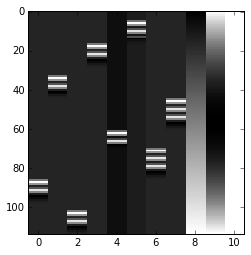

In [195]:
# show sacled design matrix for run001
plt.imshow(design_matrix["sub001_run001"], aspect=0.1, interpolation= "nearest", cmap="gray")

In [196]:
# reshape img to 2d
sub1_cs_2d = batch_convert_2d(sub1_cs_img)

In [197]:
# check keys in design matrix
design_matrix.keys()

['sub001_run012',
 'sub001_run006',
 'sub001_run007',
 'sub001_run004',
 'sub001_run005',
 'sub001_run002',
 'sub001_run003',
 'sub001_run001',
 'sub001_run011',
 'sub001_run010',
 'sub001_run008',
 'sub001_run009']

In [198]:
# check keys in 2d img
sub1_cs_2d.keys()

['sub001_run001',
 'sub001_run006',
 'sub001_run007',
 'sub001_run004',
 'sub001_run005',
 'sub001_run002',
 'sub001_run003',
 'sub001_run012',
 'sub001_run011',
 'sub001_run009',
 'sub001_run008',
 'sub001_run010']

In [199]:
# test linear regression 
beta1 = {}
t1 = {}
df1 = {}
p1 = {}
for key in sub1_cs_2d.keys():
    beta1[key], t1[key], df1[key], p1[key] = t_stat(sub1_cs_2d[key].T, design_matrix[key],[1,1,1,1,1,1,1,1,1,1,1])

/Users/tzuchieh/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:85: RuntimeWarning: invalid value encountered in true_divide


In [200]:
for i, j in beta1.iteritems():
    print (j.shape)

(11, 163840)
(11, 163840)
(11, 163840)
(11, 163840)
(11, 163840)
(11, 163840)
(11, 163840)
(11, 163840)
(11, 163840)
(11, 163840)
(11, 163840)
(11, 163840)


In [201]:
# object_list
object_list

['bottle', 'cat', 'chair', 'face', 'house', 'scissors', 'scrambledpix', 'shoe']

In [202]:
# average beta for odd runs or even runs
odd_beta = (beta1["sub001_run001"]+beta1["sub001_run003"]+beta1["sub001_run005"]+beta1["sub001_run007"]+beta1["sub001_run009"]+beta1["sub001_run011"])/6
even_beta = (beta1["sub001_run002"]+beta1["sub001_run004"]+beta1["sub001_run006"]+beta1["sub001_run008"]+beta1["sub001_run010"]+beta1["sub001_run012"])/6

In [203]:
odd_beta.shape

(11, 163840)

In [204]:
even_beta.shape

(11, 163840)

In [205]:
odd_bottle = np.reshape(odd_beta[0,:], (40,64,64))

In [206]:
even_bottle = np.reshape(even_beta[0,:], (40,64,64))

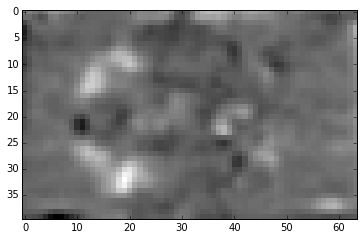

In [207]:
plt.imshow(odd_bottle[:,:,28], interpolation="nearest", cmap = "gray")

In [208]:
# similarity from bottle to bottle
bottle_bottle = np.corrcoef(odd_beta[0,:], even_beta[4,:])

In [209]:
bottle_bottle

array([[ 1.        ,  0.27040317],
       [ 0.27040317,  1.        ]])